In [158]:
# Importation de la base de donnée, une seule feuille dans le fichier donc pas de pbl
import pandas as pd

df = pd.read_excel("NA.xlsx")
print(type(df))  # vérifier que c'est bien un DataFrame

# Conversion en datetime
Y_col = 'actual \nCountry Overshoot Day \n2018'
df[Y_col] = pd.to_datetime(df[Y_col], errors='coerce')

# Extraire jour et mois
df['day'] = df[Y_col].dt.day
df['month'] = df[Y_col].dt.month

# Concaténer mois et jour en format "MM-DD"
df['Overshoot_day_month'] = df['month'].astype(str).str.zfill(2) + "-" + df['day'].astype(str).str.zfill(2)

df = df.drop(columns=['day', 'month'])

print(df.columns) 
print(df['Overshoot_day_month'])


<class 'pandas.core.frame.DataFrame'>
Index(['Country', 'Quality Score', 'SDGi', 'Life Expectancy', 'HDI',
       'Per Capita GDP', 'Region', 'Income Group', 'Population (millions)',
       'Cropland Footprint', 'Grazing Footprint', 'Forest Product Footprint',
       'Fish Footprint', 'Built up land', 'Carbon Footprint',
       'Total Ecological Footprint (Production)', 'Cropland Footprint.1',
       'Grazing Footprint.1', 'Forest Product Footprint.1', 'Fish Footprint.1',
       'Built up land.1', 'Carbon Footprint.1',
       'Total Ecological Footprint (Consumption)', 'Cropland', 'Grazing land',
       'Forest land', 'Fishing ground', 'Built up land.2',
       'Total biocapacity ', 'Ecological (Deficit) or Reserve',
       'Number of Earths required', 'Number of Countries required',
       'actual \nCountry Overshoot Day \n2018', 'Overshoot_day_month'],
      dtype='object')
0       nan-nan
1      11.0-1.0
2       9.0-2.0
3       nan-nan
4       5.0-3.0
         ...   
179    8.0-28.0

Afficher le nombre de lignes et de colonnes :

In [63]:
# nombre de lignes :
print(len(df))

184


Il y a donc  184 pays.

In [159]:
# nombre de lignes :
print(len(df.columns))

34


Il y a donc 33 colonnes + Overshoot_day_month

Création de la vatiable de réponse Y et de la matrice de variables explicatives : X

In [160]:
Y_col = "Overshoot_day_month"

# X_cols ne prend pas la colonne nom_pays + prend l id pour retrouver les pays
cols_to_include = df.columns[:-2] # pas les 2 overshoulday

cols = [col for col in cols_to_include if col != Y_col]

X_cols = list(cols_to_include)

print(X_cols) # si 31 alors ok


['Country', 'Quality Score', 'SDGi', 'Life Expectancy', 'HDI', 'Per Capita GDP', 'Region', 'Income Group', 'Population (millions)', 'Cropland Footprint', 'Grazing Footprint', 'Forest Product Footprint', 'Fish Footprint', 'Built up land', 'Carbon Footprint', 'Total Ecological Footprint (Production)', 'Cropland Footprint.1', 'Grazing Footprint.1', 'Forest Product Footprint.1', 'Fish Footprint.1', 'Built up land.1', 'Carbon Footprint.1', 'Total Ecological Footprint (Consumption)', 'Cropland', 'Grazing land', 'Forest land', 'Fishing ground', 'Built up land.2', 'Total biocapacity ', 'Ecological (Deficit) or Reserve', 'Number of Earths required', 'Number of Countries required']


Génération du jeu de données du S1, sans aucune ligne contenant au mins une NA : 

In [161]:
import numpy as np

# on prend df en on supprime les lignes ou il y a des données NA parmis les X ou Y :

df["Per Capita GDP"] = (
    df["Per Capita GDP"]
    .replace("-", np.nan)
)

df["Overshoot_day_month"] = (
    df["Overshoot_day_month"]
    .replace("nan-nan", np.nan)
)

df["Per Capita GDP"] = pd.to_numeric(
    df["Per Capita GDP"], errors="coerce"
)

s_un = df.dropna(subset=X_cols + [Y_col])

print(len(s_un))

106


C:\Users\annac\AppData\Local\Temp\ipykernel_26752\3375722286.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("-", np.nan)


Nous avons donc 109 lignes

Pour réaliser les prédictions, commençons par séparer le jeu de données en X et Y :

In [162]:
# Séparation X / y

X = s_un[X_cols[1:]]
print(X.columns)

country = s_un[X_cols[0]]
print(country)

y = s_un[Y_col]

# Avant d'apprendre, il faut gerer les colonnes non numeriques : 
for col in X_cols[1:]: 
    if df[col].dtype == 'object': 
        print(col) 
        
# Il y a donc 3 colonnes a gerer, elles sont catégorielles :

categorical_cols = ['Quality Score', 'Region', 'Income Group']

# Encodage
X_encoded = pd.get_dummies(
    X,
    columns=categorical_cols,
    drop_first=True
)

print(X)

Index(['Quality Score', 'SDGi', 'Life Expectancy', 'HDI', 'Per Capita GDP',
       'Region', 'Income Group', 'Population (millions)', 'Cropland Footprint',
       'Grazing Footprint', 'Forest Product Footprint', 'Fish Footprint',
       'Built up land', 'Carbon Footprint',
       'Total Ecological Footprint (Production)', 'Cropland Footprint.1',
       'Grazing Footprint.1', 'Forest Product Footprint.1', 'Fish Footprint.1',
       'Built up land.1', 'Carbon Footprint.1',
       'Total Ecological Footprint (Consumption)', 'Cropland', 'Grazing land',
       'Forest land', 'Fishing ground', 'Built up land.2',
       'Total biocapacity ', 'Ecological (Deficit) or Reserve',
       'Number of Earths required', 'Number of Countries required'],
      dtype='object')
1                       Albania
2                       Algeria
5                     Argentina
6                       Armenia
7                     Australia
                 ...           
173        United Arab Emirates
174    

Nous avons maintenant X_encoded, regardons sont nombre de colonnes, normalement il a toujours 109 lignes

In [68]:
print(len(X_encoded))
print(len(X_encoded.columns))

106
39


In [163]:
# Avant tout, convertir la target en numérique :
import pandas as pd

def month_day_to_numeric(s):
    """Convert 'month-day' string with possible floats to day-of-year (year=2018)."""
    if pd.isna(s):
        return None
    try:
        # séparer mois et jour
        month_str, day_str = s.split('-')
        # convertir en float puis en int
        month = int(float(month_str))
        day = int(float(day_str))
        # créer la date avec année 2018
        dt = pd.Timestamp(year=2018, month=month, day=day)
        return dt.dayofyear
    except:
        return None

# Appliquer à la colonne
print(y)
y = y.apply(month_day_to_numeric)

# Vérifier
print(y.head(100))

1       11.0-1.0
2        9.0-2.0
5       6.0-22.0
6      10.0-29.0
7       3.0-21.0
         ...    
173     3.0-11.0
174     5.0-17.0
175     3.0-11.0
177     10.0-9.0
180     9.0-10.0
Name: Overshoot_day_month, Length: 106, dtype: object
1      305
2      245
5      173
6      302
7       80
      ... 
163    244
167     76
168    284
169    171
170    116
Name: Overshoot_day_month, Length: 100, dtype: int64


Il y a donc 41 colonnes, c'est bormale car en encodant, nous en avons créé de nouvelles

Maintenant que c'est fait, je split mon jeu de données afin de créer le train et le test :

In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    # je separe en 20% test et 80% train
    test_size=0.2, 
    # j'ai mit une graine afin d'avoir toujours les mêmes résultats
    random_state=123
)


print(X_test)

     SDGi  Life Expectancy    HDI  Per Capita GDP  Population (millions)  \
85   79.8          84.2110  0.917    48505.526643             127.202000   
44   81.4          79.0293  0.898    23720.899272              10.665700   
103  70.9          75.9970  0.805    12116.214159              31.528000   
170  61.1          68.0730  0.710     7647.951725               5.850900   
158  85.6          82.5585  0.943    59067.517556               9.971640   
148  81.6          81.3781  0.912    26709.658902               2.077840   
13   68.4          79.0810  0.810    16136.910427               0.286641   
8    82.1          81.6927  0.921    49711.014529               8.891390   
1    71.0          78.4580  0.792     5046.032611               2.882740   
100  74.2          82.2951  0.913   111380.649478               0.604245   
137  73.8          72.6622  0.823    11939.561118             145.734000   
7    75.6          82.7488  0.943    57032.237052              24.898199   
51   67.9   

In [71]:
print(y_test)

85     124
44     100
103    134
170    116
158     91
148    106
13     144
8       94
1      305
100     44
137    107
7       80
51     283
144    187
18     110
64     248
117    100
67     139
70     316
35     310
34     151
82     122
Name: Overshoot_day_month, dtype: int64


Je crée le modèle linéaire :

In [165]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()
train = model.fit(X_train, y_train)

# prédiction sur les données de X_test
y_pred = train.predict(X_test)
y_pred = y_pred.astype(int)  # convertit chaque élément en entier
print(y_pred)

[167  95 175 219 109 107 187 104 207   9 140  54 345 183 213 250 101 128
 325 237 289 131]


In [166]:
import pandas as pd

# Créer un DataFrame avec les résultats
results = pd.DataFrame({
    'Country': country.loc[X_test.index],  # récupérer les noms des pays correspondants aux indices de X_test
    'y_test': y_test,
    'y_pred': y_pred,
    'Error': y_test - y_pred
})

# Afficher
print(results)


                Country  y_test  y_pred  Error
85                Japan     124     167    -43
44       Czech Republic     100      95      5
103            Malaysia     134     175    -41
170        Turkmenistan     116     219   -103
158              Sweden      91     109    -18
148            Slovenia     106     107     -1
13             Barbados     144     187    -43
8               Austria      94     104    -10
1               Albania     305     207     98
100          Luxembourg      44       9     35
137  Russian Federation     107     140    -33
7             Australia      80      54     26
51          El Salvador     283     345    -62
144              Serbia     187     183      4
18               Bhutan     110     213   -103
64              Georgia     248     250     -2
117         Netherlands     100     101     -1
67               Greece     139     128     11
70            Guatemala     316     325     -9
35             Colombia     310     237     73
34           

Calcul de la moyenne quadratique :

In [167]:
import numpy as np

rms = np.sqrt(np.mean((y_test - y_pred)**2))
print(rms)


55.66213010003055


En moyenne, notre modèle se trompe d’environ ±57 jours sur la date de l’Overshoot Day.

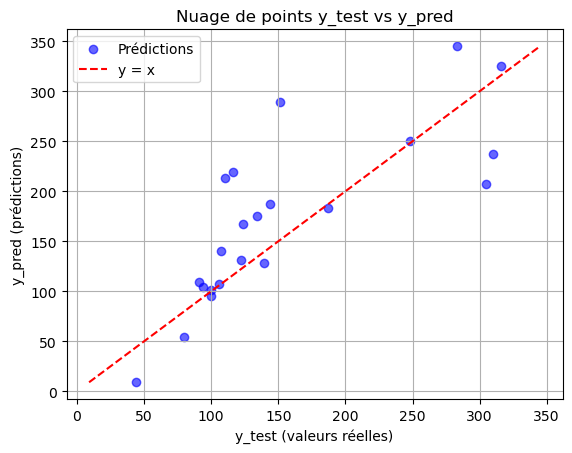

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# Nuage de points
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Prédictions')

# Droite de régression y = x pour comparer
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

# Labels et titre
plt.xlabel('y_test (valeurs réelles)')
plt.ylabel('y_pred (prédictions)')
plt.title('Nuage de points y_test vs y_pred')
plt.legend()
plt.grid(True)
plt.show()


2) Modèle sans colinéarité :

In [2]:
# Importation de la base de donnée, une seule feuille dans le fichier donc pas de pbl
import pandas as pd

df = pd.read_excel("NA.xlsx")

# Conversion en datetime
Y_col = 'actual \nCountry Overshoot Day \n2018'
df[Y_col] = pd.to_datetime(df[Y_col], errors='coerce')

# Extraire jour et mois
df['day'] = df[Y_col].dt.day
df['month'] = df[Y_col].dt.month

# Concaténer mois et jour en format "MM-DD"
df['Overshoot_day_month'] = df['month'].astype(str).str.zfill(2) + "-" + df['day'].astype(str).str.zfill(2)

df = df.drop(columns=['day', 'month'])

print(df['Overshoot_day_month'])


Y_col = "Overshoot_day_month"

# X_cols ne prend pas la colonne nom_pays + prend l id pour retrouver les pays

cols_to_include = ['Country','SDGi','Life Expectancy', 'HDI', 'Per Capita GDP',  
    'Population (millions)', 'Cropland Footprint', 
    'Grazing Footprint', 'Forest Product Footprint',  
    'Fish Footprint', 
    'Cropland Footprint', 'Grazing Footprint', 
    'Forest Product Footprint','Fish Footprint', 
    'Grazing land', 'Forest land', 'Fishing ground', 'Ecological (Deficit) or Reserve', 
    'Number of Countries required'] # pas les 2 overshoulday


X_cols = cols_to_include

print(X_cols) # si 31 alors ok


0       nan-nan
1      11.0-1.0
2       9.0-2.0
3       nan-nan
4       5.0-3.0
         ...   
179    8.0-28.0
180    9.0-10.0
181     nan-nan
182     nan-nan
183     nan-nan
Name: Overshoot_day_month, Length: 184, dtype: object
['Country', 'SDGi', 'Life Expectancy', 'HDI', 'Per Capita GDP', 'Population (millions)', 'Cropland Footprint', 'Grazing Footprint', 'Forest Product Footprint', 'Fish Footprint', 'Cropland Footprint', 'Grazing Footprint', 'Forest Product Footprint', 'Fish Footprint', 'Grazing land', 'Forest land', 'Fishing ground', 'Ecological (Deficit) or Reserve', 'Number of Countries required']


In [3]:
cols_to_include_existing = [col for col in cols_to_include if col in df.columns]
len(cols_to_include_existing)

19

In [4]:
import pandas as pd
import numpy as np

# Suppression des lignes avec NA dans X ou Y

# Convertir "Per Capita GDP" en numérique
df["Per Capita GDP"] = df["Per Capita GDP"].replace("-", np.nan)
df["Per Capita GDP"] = pd.to_numeric(df["Per Capita GDP"], errors="coerce")

# Remplacer "nan-nan" dans Overshoot_day_month par NaN
df["Overshoot_day_month"] = df["Overshoot_day_month"].replace("nan-nan", np.nan)

# Supprimer les lignes avec NA dans X ou Y
s_un = df.dropna(subset=X_cols + [Y_col])

# Séparation X / y

# X = toutes les colonnes sauf la première (country)
X = s_un[X_cols[1:]]
print("Colonnes X :")
print(X)

# country = première colonne
country = s_un[X_cols[0]]
print(country)

# y = target
y = s_un[Y_col]

print(y)

Colonnes X :
     SDGi  Life Expectancy    HDI  Per Capita GDP  Population (millions)  \
1    71.0          78.4580  0.792     5046.032611               2.882740   
2    70.9          76.6930  0.746     4759.830054              42.228398   
5    72.8          76.5200  0.842    10076.395406              44.361102   
6    71.8          74.9450  0.771     4406.741763               2.951750   
7    75.6          82.7488  0.943    57032.237052              24.898199   
..    ...              ...    ...             ...                    ...   
173  70.2          77.8140  0.889    41325.060182               9.630960   
174  80.0          81.2561  0.928    42894.354268              67.141703   
175  76.0          78.6390  0.925    54723.995402             327.096000   
177  69.8          71.5730  0.717     2408.610055              32.476199   
180  72.8          75.3170  0.700     1967.638624              95.546000   

     Cropland Footprint  Grazing Footprint  Forest Product Footprint  \
1 

C:\Users\annac\AppData\Local\Temp\ipykernel_32968\2021569255.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Per Capita GDP"] = df["Per Capita GDP"].replace("-", np.nan)


In [5]:
# Conversion de la target en numérique

def month_day_to_numeric(s):
    """
    Convert 'month-day' string into day-of-year (année 2018).
    Retourne None si impossible.
    """
    if pd.isna(s):
        return None
    try:
        month_str, day_str = s.split('-')
        month = int(float(month_str))
        day = int(float(day_str))
        dt = pd.Timestamp(year=2018, month=month, day=day)
        return dt.dayofyear
    except:
        return None

y = y.apply(month_day_to_numeric)
print("Target y :")
print(y.head(10))


Target y :
1     305
2     245
5     173
6     302
7      80
8      94
9     279
11     69
13    144
14    130
Name: Overshoot_day_month, dtype: int64


In [190]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    # je separe en 20% test et 80% train
    test_size=0.2, 
    # j'ai mit une graine afin d'avoir toujours les mêmes résultats
    random_state=123
)

print(X_test)

     SDGi  Life Expectancy    HDI  Per Capita GDP  Population (millions)  \
85   79.8          84.2110  0.917    48505.526643             127.202000   
44   81.4          79.0293  0.898    23720.899272              10.665700   
103  70.9          75.9970  0.805    12116.214159              31.528000   
170  61.1          68.0730  0.710     7647.951725               5.850900   
158  85.6          82.5585  0.943    59067.517556               9.971640   
148  81.6          81.3781  0.912    26709.658902               2.077840   
13   68.4          79.0810  0.810    16136.910427               0.286641   
8    82.1          81.6927  0.921    49711.014529               8.891390   
1    71.0          78.4580  0.792     5046.032611               2.882740   
100  74.2          82.2951  0.913   111380.649478               0.604245   
137  73.8          72.6622  0.823    11939.561118             145.734000   
7    75.6          82.7488  0.943    57032.237052              24.898199   
51   67.9   

In [191]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
train = model.fit(X_train, y_train)

# prédiction sur les données de X_test
y_pred = train.predict(X_test)
y_pred = y_pred.astype(int)  # convertit chaque élément en entier
print(y_pred)

[167  95 175 219 109 107 187 104 207   9 140  54 345 183 213 250 101 128
 325 237 289 131]


In [184]:
import pandas as pd

# Créer un DataFrame avec les résultats
results = pd.DataFrame({
    'Country': country.loc[X_test.index],  # récupérer les noms des pays correspondants aux indices de X_test
    'y_test': y_test,
    'y_pred': y_pred,
    'Error': y_test - y_pred
})

# Afficher
print(results)

                Country  y_test  y_pred  Error
85                Japan     124     167    -43
44       Czech Republic     100      95      5
103            Malaysia     134     175    -41
170        Turkmenistan     116     219   -103
158              Sweden      91     109    -18
148            Slovenia     106     107     -1
13             Barbados     144     187    -43
8               Austria      94     104    -10
1               Albania     305     207     98
100          Luxembourg      44       9     35
137  Russian Federation     107     140    -33
7             Australia      80      54     26
51          El Salvador     283     345    -62
144              Serbia     187     183      4
18               Bhutan     110     213   -103
64              Georgia     248     250     -2
117         Netherlands     100     101     -1
67               Greece     139     128     11
70            Guatemala     316     325     -9
35             Colombia     310     237     73
34           

In [185]:
import numpy as np

rms = np.sqrt(np.mean((y_test - y_pred)**2))
print(rms)

55.66213010003055
